In [0]:
#Sentiment Analysis on Movie Reviews
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p GuodongDrive
!google-drive-ocamlfuse GuodongDrive

In [0]:
import os
os.chdir("GuodongDrive")
!ls

 aclImdb_v1.tar.gz	 Sense.ipynb
 data_description.txt	 sensePY.ipynb
 drive			'Sentiment Analysis on Movie Reviews'
 GuodongDrive		 submission.csv
 House			 test.csv
'House price'		 testData.tsv
 Houseprice.ipynb	 Titanic
 huawei			 torchtest.ipynb
 labeledTrainData.tsv	 train.csv
'movie review'		 Untitled0.ipynb
 neg			 word_to_vec
 practice		 XGboost_practice1.ipynb
 residual_plot.png	 XGboost_practice2.ipynb
 Sales			 Yi
 sample_submission.csv	 剑指offer
 Sense1.ipynb		 数组和链表.desktop
 Sense2.ipynb（副本）	 糖尿病数据.txt


In [0]:
os.chdir("Sentiment Analysis on Movie Reviews")
!ls

 sampleSubmission.csv			      test.tsv
'Sentiment Analysis on Movie Reviews.ipynb'   train.tsv


#LSTM vs ML

这个kernal主要是比较Long-Short Term memory solution (LSTM) 和传统机器学习模型对于情感分类比较的结果，也是对LSTM的简单应用，框架是用的tf

In [0]:
import re
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
from sklearn import metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


In [46]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
df_train = pd.read_csv('train.tsv',sep='\t')
df_test = pd.read_csv('test.tsv',sep = '\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Phrase 是被打乱的短语，sentenceid是被打乱的短语所属于的句子

**描述性分析**

这部分通过有效的分析工具来帮助我们判断是否需要用stop words

In [0]:
stop_word = set(stopwords.words('english'))
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.001)
sparse_matrix = word_vectorizer.fit_transform(df_test['Phrase'])
sparse_matrix

<66292x744 sparse matrix of type '<class 'numpy.int64'>'
	with 246000 stored elements in Compressed Sparse Row format>

**得到出现词的频次，做成一个数组**

In [0]:
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
freq.sort_values('frequency', ascending=False)

,frequency
the,20181
and,12594
of,12508
to,9142
in,5658
is,5322
it,4857
that,4531
as,3366
with,2972


可视化数据

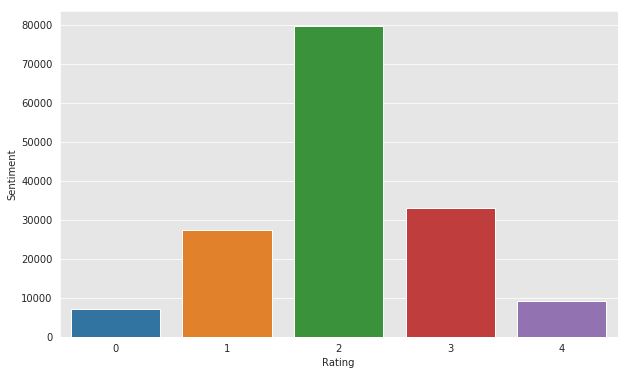

In [0]:
a = df_train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

#数据处理:

1.变成小写字母

2.数据只保留字母和数字

In [0]:
df_train['Phrase'] = df_train['Phrase'].str.lower()
df_train['Phrase'] = df_train['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df_test['Phrase'] = df_test['Phrase'].str.lower()
df_test['Phrase'] = df_test['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df_train
#re.sup是替换

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [0]:
X_train = df_train.Phrase
y_train = df_train.Sentiment
tokenize = Tokenizer()
tokenize.fit_on_texts(X_train.values)

In [0]:
X_test = df_test.Phrase
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [0]:
X_train

[[2,
  304,
  3,
  15089,
  5910,
  1,
  6506,
  9,
  51,
  8,
  49,
  13,
  1,
  3513,
  8,
  167,
  49,
  13,
  1,
  11370,
  62,
  3,
  75,
  616,
  10448,
  19,
  576,
  3,
  75,
  2006,
  5,
  54,
  3,
  2,
  40],
 [2, 304, 3, 15089, 5910, 1, 6506, 9, 51, 8, 49, 13, 1, 3513],
 [2, 304],
 [2],
 [304],
 [3, 15089, 5910, 1, 6506, 9, 51, 8, 49, 13, 1, 3513],
 [3],
 [15089, 5910, 1, 6506, 9, 51, 8, 49, 13, 1, 3513],
 [15089],
 [5910, 1, 6506, 9, 51, 8, 49, 13, 1, 3513],
 [5910, 1, 6506],
 [5910],
 [1, 6506],
 [1],
 [6506],
 [9, 51, 8, 49, 13, 1, 3513],
 [9],
 [51, 8, 49, 13, 1, 3513],
 [51],
 [8, 49, 13, 1, 3513],
 [8],
 [49, 13, 1, 3513],
 [49],
 [13, 1, 3513],
 [13],
 [1, 3513],
 [3513],
 [8,
  167,
  49,
  13,
  1,
  11370,
  62,
  3,
  75,
  616,
  10448,
  19,
  576,
  3,
  75,
  2006,
  5,
  54,
  3,
  2,
  40],
 [8,
  167,
  49,
  13,
  1,
  11370,
  62,
  3,
  75,
  616,
  10448,
  19,
  576,
  3,
  75,
  2006,
  5,
  54,
  3,
  2,
  40],
 [8, 167],
 [167],
 [49,
  13,
  1,
  1

In [0]:
max_length = max([len(s.split()) for s in df_train['Phrase']])
X_train = pad_sequences(X_train,max_length)
X_test = pad_sequences(X_test,max_length)

**pad_sequence**

将多个序列截断或补齐为相同长度。

该函数将一个 num_samples 的序列（整数列表）转化为一个 2D Numpy 矩阵，其尺寸为 (num_samples, num_timesteps)。 num_timesteps 要么是给定的 maxlen 参数，要么是最长序列的长度。

比 num_timesteps 短的序列将在末端以 value 值补齐。

比 num_timesteps 长的序列将会被截断以满足所需要的长度。补齐或截断发生的位置分别由参数 pading 和 truncating 决定。

向前补齐为默认操作。

参数

sequences: 列表的列表，每一个元素是一个序列。
maxlen: 整数，所有序列的最大长度。
dtype: 输出序列的类型。 要使用可变长度字符串填充序列，可以使用 object。
padding: 字符串，'pre' 或 'post' ，在序列的前端补齐还是在后端补齐。
truncating: 字符串，'pre' 或 'post' ，移除长度大于 maxlen 的序列的值，要么在序列前端截断，要么在后端。
value: 浮点数，表示用来补齐的值

In [0]:
print(X_train.shape)
print(X_test.shape)

(156060, 48)
(66292, 48)


In [0]:
print(y_train.shape)
print(X_train.shape)

(156060,)
(156060, 48)


#建立模型

**这里作者使用了三隐层**

In [0]:
Embedding_Dim = 100
unknown = len(tokenize.word_index)+1
model = Sequential()
model.add(Embedding(unknown,Embedding_Dim,input_length = max_length))
model.add(LSTM(units = 128,dropout =0.2,recurrent_dropout = 0.2))
model.add(Dense(5,activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 100)           1637800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,755,693
Trainable params: 1,755,693
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1)#运行的时候verbose为0，后来我改成了1，但没有再运行，运行时间较长

W0809 06:14:11.417670 139748384671616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
final_pred = model.predict_classes(X_test)

在作者使用深度学习框架之前，还尝试了SVM和RF：

In [42]:
df_train = pd.read_csv('train.tsv',sep = '\t')
df_train['Phrase'] = df_train['Phrase'].str.lower()
stop_word = set(stopwords.words('english'))
stop_word

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
df_train['tokezines_sents'] = df_train.apply(lambda x: nltk.word_tokenize(x['Phrase']),axis =1)
df_train

,PhraseId,SentenceId,Phrase,Sentiment,tokezines_sents
0,1,1,a series of escapades demonstrating the adage ...,1,"[a, series, of, escapades, demonstrating, the,..."
1,2,1,a series of escapades demonstrating the adage ...,2,"[a, series, of, escapades, demonstrating, the,..."
2,3,1,a series,2,"[a, series]"
3,4,1,a,2,[a]
4,5,1,series,2,[series]
5,6,1,of escapades demonstrating the adage that what...,2,"[of, escapades, demonstrating, the, adage, tha..."
6,7,1,of,2,[of]
7,8,1,escapades demonstrating the adage that what is...,2,"[escapades, demonstrating, the, adage, that, w..."
8,9,1,escapades,2,[escapades]
9,10,1,demonstrating the adage that what is good for ...,2,"[demonstrating, the, adage, that, what, is, go..."


In [51]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: [stemmer.stem(y) for y in x])
df_train

,PhraseId,SentenceId,Phrase,Sentiment,tokezines_sents
0,1,1,a series of escapades demonstrating the adage ...,1,"[a, seri, of, escapad, demonstr, the, adag, th..."
1,2,1,a series of escapades demonstrating the adage ...,2,"[a, seri, of, escapad, demonstr, the, adag, th..."
2,3,1,a series,2,"[a, seri]"
3,4,1,a,2,[a]
4,5,1,series,2,[seri]
5,6,1,of escapades demonstrating the adage that what...,2,"[of, escapad, demonstr, the, adag, that, what,..."
6,7,1,of,2,[of]
7,8,1,escapades demonstrating the adage that what is...,2,"[escapad, demonstr, the, adag, that, what, is,..."
8,9,1,escapades,2,[escapad]
9,10,1,demonstrating the adage that what is good for ...,2,"[demonstr, the, adag, that, what, is, good, fo..."


In [52]:
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: ' '.join(x))
df_train

,PhraseId,SentenceId,Phrase,Sentiment,tokezines_sents
0,1,1,a series of escapades demonstrating the adage ...,1,a seri of escapad demonstr the adag that what ...
1,2,1,a series of escapades demonstrating the adage ...,2,a seri of escapad demonstr the adag that what ...
2,3,1,a series,2,a seri
3,4,1,a,2,a
4,5,1,series,2,seri
5,6,1,of escapades demonstrating the adage that what...,2,of escapad demonstr the adag that what is good...
6,7,1,of,2,of
7,8,1,escapades demonstrating the adage that what is...,2,escapad demonstr the adag that what is good fo...
8,9,1,escapades,2,escapad
9,10,1,demonstrating the adage that what is good for ...,2,demonstr the adag that what is good for the goos


In [0]:
from sklearn.model_selection import train_test_split
x=df_train.tokezines_sents
y=df_train.Sentiment
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,  random_state=1)

In [55]:
x_train_df = vect.fit_transform(X_train)
x_test_df = vect.transform(X_test)
print('Number of features:', len(vect.get_feature_names()))

Number of features: 10730


In [56]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_df, y_train)
y_pred_class = nb.predict(x_test_df)
print('NB:', metrics.accuracy_score(y_test, y_pred_class))
from sklearn.linear_model import SGDClassifier
SVM = SGDClassifier()
SVM.fit(x_train_df, y_train)
y_pred_class = SVM.predict(x_test_df)
print('SVM:', metrics.accuracy_score(y_test, y_pred_class))

NB: 0.612392669486095
SVM: 0.6065295399205434


In [57]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train_df, y_train)
y_pred_class = rfc.predict(x_test_df)
print('RF:',metrics.accuracy_score(y_test, y_pred_class))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.6246956298859413


[参考链接](https://www.kaggle.com/stass30/result-0-66-lstm-vs-machine-learning)